In [79]:
import scipy
from numpy import genfromtxt
import matplotlib.pyplot as mpl
import numpy as np
import scipy.optimize as opt
from scipy import integrate
import math

#import the csv data file into python
#data_file = 'daily.csv'
data_file = 'C:\\Users\\cassi\\Documents\\GitHub\\CompPhysSunspots\\daily.csv'

data = genfromtxt(data_file, delimiter=';')

#save the time when sunspots are recorded in array "year"
year = data[:,3]
#save the number of spots in array "spots" corresponding to same index in array year
spots = data[:,4]

#Save whatever index where spots has a value of -1, which means there was bad data
bad_data = np.argwhere(spots==-1)
#print(len(spots)) #length of spots befre deletion
#print(len(bad_data)) #number of elements to be deleted

#Delete the bad values
spots = np.delete(spots, bad_data)
year = np.delete(year, bad_data)
N = len(spots)

#Fit the year data between values of 0 and 1 instead of from initial time to final time of array
'''y0 = year[0]
diff = year[N-1] - y0
#print(diff)
for i in range(len(year)):
    year[i] = (year[i]-y0)/diff'''

'y0 = year[0]\ndiff = year[N-1] - y0\n#print(diff)\nfor i in range(len(year)):\n    year[i] = (year[i]-y0)/diff'

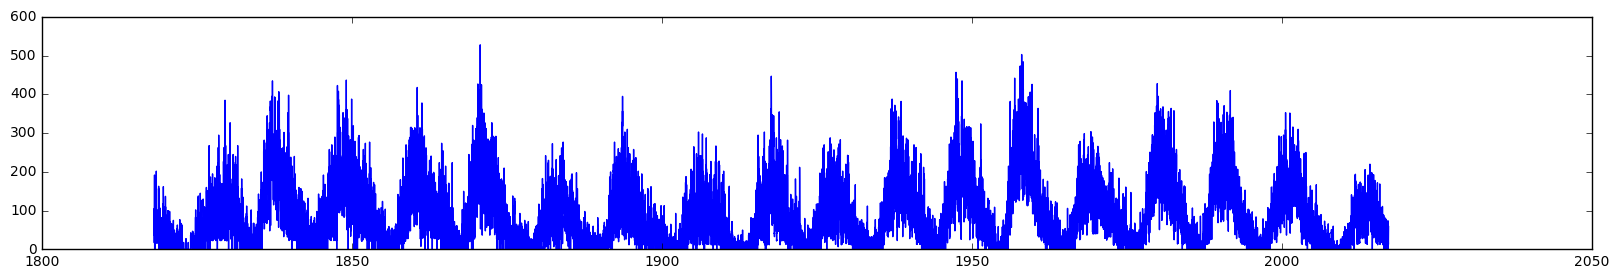

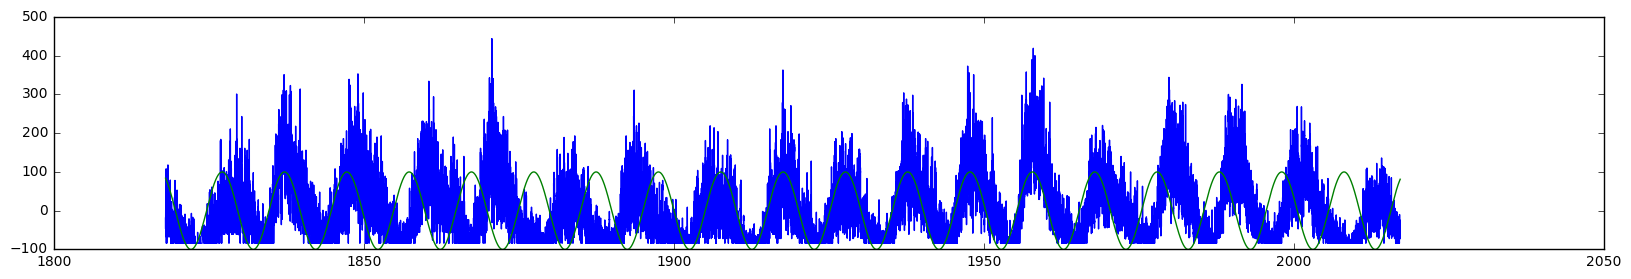

In [59]:
#Set up plot to show sunspot data
mpl.figure(figsize=(20,3))
mpl.clf()
mpl.plot(year,spots)
mpl.show()

#compute mean value of sunspots
mean = 0
for x in spots:
    mean+=x
mean/=N

#remove constant offset
for i in range(N):
    spots[i]-=mean

#plot this modified function
#Interestng note: this plots significantly faster when the year array is normalized from 0 to 1
#as compared to the initial array starting at actual initial year on the order of 10**4
mpl.figure(figsize=(20,3))
mpl.clf()
mpl.plot(year,spots)
mpl.plot(year,-100*np.sin(.625*year))
mpl.show()

#compute mean square
meansq = 0
for x in spots:
    meansq+=x**2
meansq/=N


In [107]:
#Schuster sum takes a single frequency w, and array t and x of equal length. 
#It also takes an input of a trigonometic function that will modify the inputs and return a value c
def schuster_sum(w,t,x,trigfunc):
    #assert t and x are equal length
    if len(t) != len(x):
        print("t and x must be equal length")
    c = 0
    for k in range(0,len(t)):
        c += x[k]*trigfunc(w*t[k])
    return c

#Schuster sum returns the Schuster periodogram of the args frequency w, array of times t, and corresponding dependent array x
#It indicates how well the function of frequency w models the periodic data x(t)
def schuster(w,t,x):
    sin_sum = schuster_sum(w, t,x, math.sin)
    cos_sum = schuster_sum(w, t,x, math.cos)
    return (sin_sum**2 + cos_sum**2)/len(t)**2



#Define the function to pass into minimize_scalar function
#Because we want to find a maximum, we can find the minimum of -1*Schuster function
#def maximize(w, bound):
    #f = -1*schuster(w,year,spots)
    maximum = opt.minimize_scalar(-1*schuster(w,year,spots),bound).x #Store the maximum schuster value
    return maximum



In [ ]:
#Schuster sum takes a single frequency w, and array t and x of equal length. 
#It also takes an input of a trigonometic function that will modify the inputs and return a value c
def schuster_sum(w,t,x,trigfunc):
    #assert t and x are equal length
    if len(t) != len(x):
        print("t and x must be equal length")
    c = 0
    for k in range(0,len(t)):
        c += x[k]*trigfunc(w*t[k])
    return c

#Schuster sum returns the Schuster periodogram of the args frequency w, array of times t, and corresponding dependent array x
#It indicates how well the function of frequency w models the periodic data x(t)
def schuster(w,t,x):
    sin_sum = schuster_sum(w, t,x, math.sin)
    cos_sum = schuster_sum(w, t,x, math.cos)
    return (sin_sum**2 + cos_sum**2)/len(t)**2

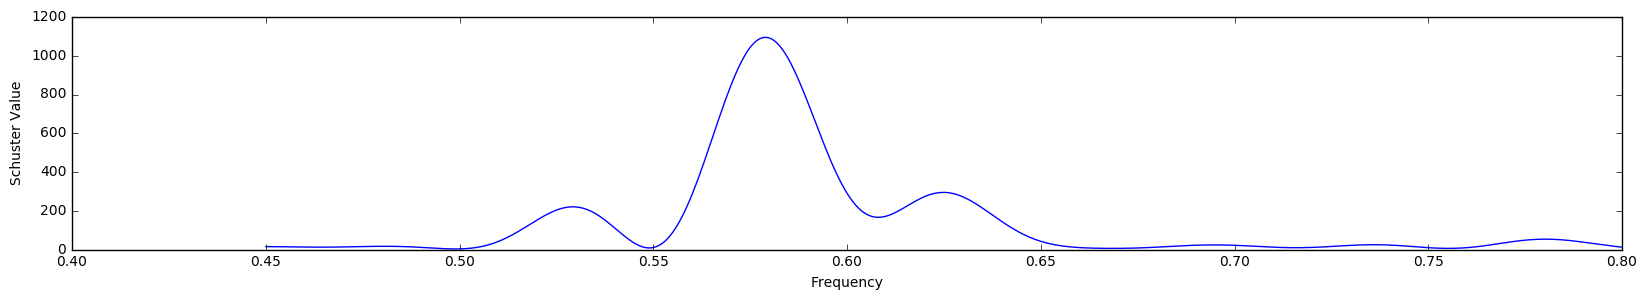

In [104]:
#compute the schuster over a range of angular frequencies
sch = []                       #store schuster values in array sch
freq = np.linspace(.45,.8,500) #If we do not bound the frequency values, we encounter a large value near 0
                               #Ideally, we would be able to find a way to correct for this
for i in range(0,len(freq)):
    sch.append(schuster(freq[i],year,spots))

#plot schuster as a function of angular frequency
mpl.figure(figsize=(20,3))
mpl.clf()
mpl.plot(freq,sch)
mpl.xlabel('Frequency')
mpl.ylabel('Schuster Value')
mpl.show()

0.578950473372


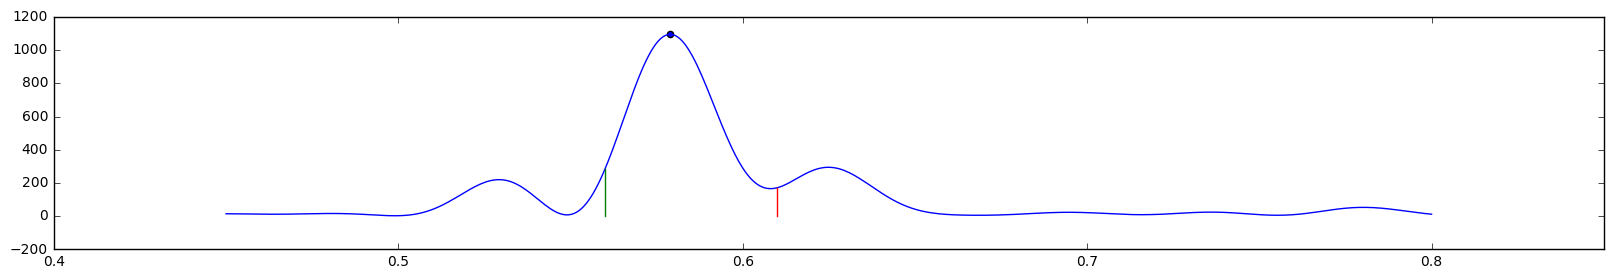

In [117]:
#Define the function to pass into minimize_scalar function
#Because we want to find a maximum, we can find the minimum of -1*f(w)
def f(w):
    return -1*schuster(w,year,spots)

#Define the boundaries for this particular function and maximum.
#The function must be bounded because there are many relative maxima.

#We determined the ideal bounds simply by plotting the function from zero to an arbitrarily large value,
# and then determining which relative maximum was the largest. This indicates a guess for 
# the best frequency value to model the periodicity of the data.

#To generalize this method more fully, we could analyze the maxima from 0 to a large value,
# and then determine the largest value from these relative maxima.
bound = [.56, .61]
maximum = opt.minimize_scalar(f,bound).x
print(maximum)

#plot schuster as a function of angular frequency with bounds
mpl.figure(figsize=(20,3))
mpl.clf()
mpl.plot(freq,sch)
mpl.plot([bound[0],bound[0]],[0,schuster(bound[0],year,spots)])
mpl.plot([bound[1],bound[1]],[0,schuster(bound[1],year,spots)])
mpl.scatter(maximum,schuster(maximum,year,spots))
mpl.show()

In [92]:
#Define the probability for unknown variance:
# (1-2*schuster(w)/(N*mean**2) )**(1-.5*N)
#This formula taken from (2.8) of "Lecture Notes in Statistics" by Bretthorst
def prob(w):
    base = 1-2*schuster(w,year,spots)/(N*meansq)
    exp = 1-.5*N
    return base**exp

#Compute the likelihood function over a range of angular frequencies
p = []
freq = np.linspace(.4,.9,100)
for i in range(0,len(freq)):
    p.append(prob(freq[i])-1) #the -1 is a correction since the function calculates a value that is always greater than 1.
                              #However, in order to normalize, we want the probability function to be centered around zero
                              #We are somewhat unsure as to the correctness of this correction


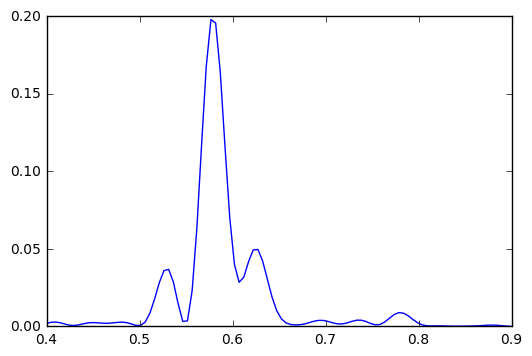

In [93]:
#Plot the probability as a function of frequency
#The peak indicates a likely frequency value that will model the periodic data well.
mpl.clf()
mpl.plot(freq,p)
mpl.show()

In [89]:
#Find a value for the variance of the data in array x.
#This function uses the standard method of finding the standard deviation for a set of data:
#Sigma = sqrt((1/N)*sum((x[j]-meanX)**2)) for N elements of x, x[j] being the jth element of the array
#Sigma should be on the order of magnitude of the average x value or less:
#the smaller the sigma value, the less noisy the data
def variance(x):
    nArray = len(x)
    meanx = 0
    sigma = 0
    for i in range(nArray-1):
        meanx += x[i]
    meanx /= nArray
    for j in range(nArray-1):
        sigma += (x[j] - meanx)**2
    #print(meanx)
    sigma /= nArray
    sigma = math.sqrt(sigma)
    return sigma
        
    
    
    
#Define a probability function for the Schuster periodogram using a known sigma value
#Higher values for prob1 indicate a better fit of the Schuster model at the given frequency
#args: frequency 'w' (float), time values 'year' (array), number of sunspots 'spots' (array), and variance of data o (float)
def prob1(w,year, spots, o):
    return math.exp(schuster(w,year,spots)/o**2)



21.715256497106434


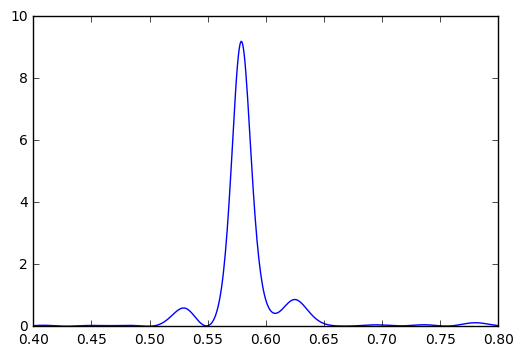

In [94]:
#Find those elements within a range of years determined to have little to no periodicity. 
#In this case, we took those values in the array that appear to vary around zero over a three-year span, 1876 to 1879
#'sample' stores the indices of these values.
sample = np.all([year<1879,year>1876],0)

#Pass in the number of sunspots corresponding to the indices in 'sample.'
#Then take the variance of this set of values.
o = variance(spots[sample]) 
print (o)

#We found the variance to be within our expectations. Ideally, we would be able to run many tests for the variance
# at different "flat" sections of the function, and take the average of these calculated values.
#As it is, the variance may have a relatively large error that could be easily reduced by more refining of our chosen data set
# and by taking many more samplings of the variance at different ranges

   
#Plot the probablility distribution for the Schuster with known (calculated) variance.
p1 = []
freq1 = np.linspace(.4,.8,500)
for i in range(0,len(freq1)):
    p1.append(prob1(freq1[i],year,spots,o)-1) #Again, we must suubtract 1, since the minimum value of Schuster/variance**2
                                              #is zero, thus the minimum value for exp(Schuster/variance**2) is 1.
                                              #But we want a probability distribution with a minimum value of 0.   
mpl.clf()
mpl.plot(freq1,p1)
mpl.show()